In [1]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

env: DDE_BACKEND=tensorflow


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2
v_i = -0.5

In [3]:
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [4]:
def upper_wall(X, on_boundary):
  # on_upper_wall = np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2), on_boundary)
  on_upper_wall = np.logical_and(np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)), on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  # on_lower_wall = np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2),on_boundary)
  on_lower_wall = np.logical_and(np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [5]:
bc_wall_u_up = dde.DirichletBC(geom, lambda X:v_i, upper_wall, component =0)
bc_wall_u_down = dde.DirichletBC(geom, lambda X:0., lower_wall, component =0)
bc_wall_v_up = dde.DirichletBC(geom, lambda X:0., upper_wall, component =1)
bc_wall_v_down = dde.DirichletBC(geom, lambda X:0., lower_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =1)

In [6]:
def pde(X,Y):
  du_x =dde.grad.jacobian(Y, X, i=0, j=0)
  du_y =dde.grad.jacobian(Y, X, i=0, j=1)
  dv_x =dde.grad.jacobian(Y, X, i=1, j=0)
  dv_y =dde.grad.jacobian(Y, X, i=1, j=1)
  dp_x =dde.grad.jacobian(Y, X, i=2, j=0)
  dp_y =dde.grad.jacobian(Y, X, i=2, j=1)
  
  du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
  du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
  dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
  dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

  pde_u    = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho) * (du_xx+ du_yy)
  pde_v    = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx+ dv_yy)
  pde_cont = du_x + dv_y

  return [pde_u,pde_v,pde_cont]

In [7]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u_up,bc_wall_u_down,bc_wall_v_up,bc_wall_v_down,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 2000,
                    num_boundary = 200,
                    num_test = 200)

<function matplotlib.pyplot.show(close=None, block=None)>

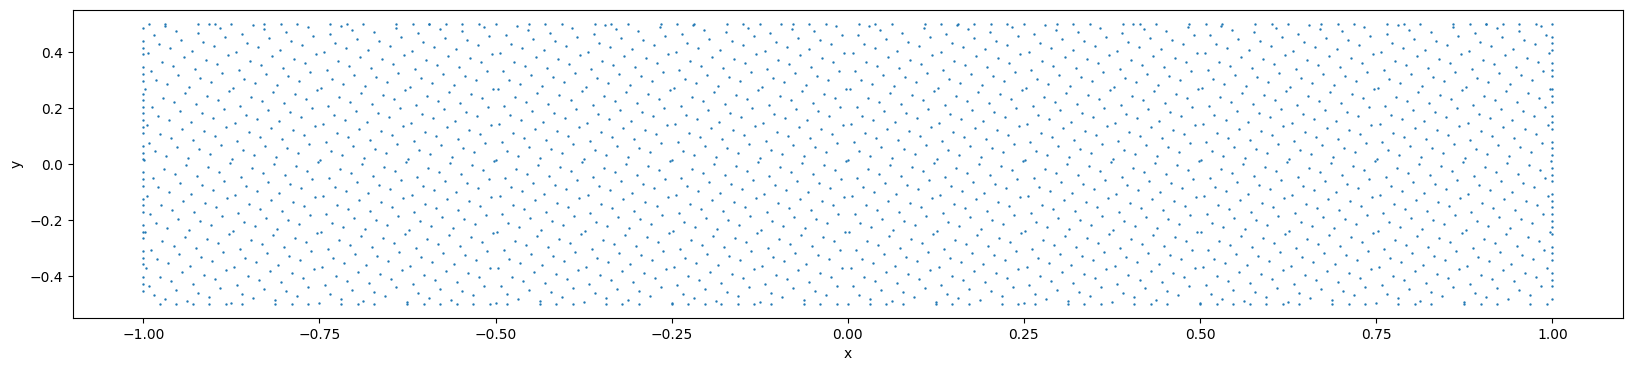

In [8]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [9]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")


In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.000504 s



In [11]:
losshistory,train_state = model.train(epochs = 10000, display_every=1000)

Training model...



c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x000002098B881CF0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002098B881CF0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002098B882050>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002098B

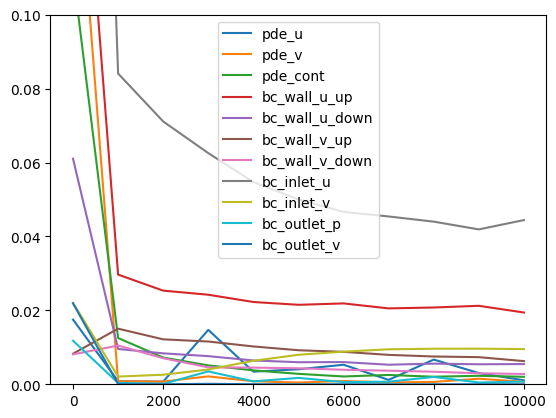

In [12]:

plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up","bc_wall_u_down","bc_wall_v_up","bc_wall_v_down","bc_inlet_u","bc_inlet_v","bc_outlet_p","bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend() 
plt.ylim([0, 0.1])
plt.show()

In [13]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 0.073944 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
10000     [2.66e-03, 8.83e-04, 4.92e-03, 1.94e-02, 5.47e-03, 6.26e-03, 2.79e-03, 4.44e-02, 9.52e-03, 7.36e-04, 4.57e-06]    [1.07e-03, 6.73e-04, 2.02e-03, 1.94e-02, 5.47e-03, 6.26e-03, 2.79e-03, 4.44e-02, 9.52e-03, 7.36e-04, 4.57e-06]    []  


KeyboardInterrupt: 

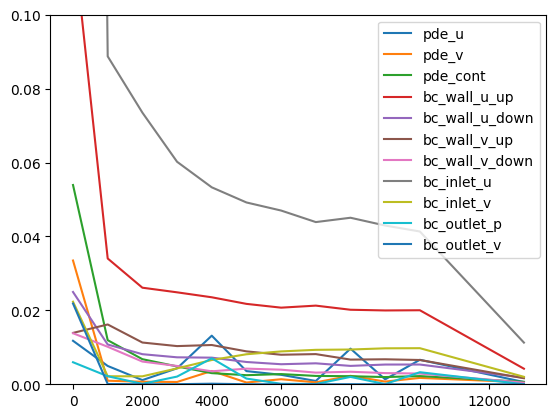

In [ ]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up","bc_wall_u_down","bc_wall_v_up","bc_wall_v_down","bc_inlet_u","bc_inlet_v","bc_outlet_p","bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [ ]:
samples= geom.random_points(500000)
result = model.predict(samples)

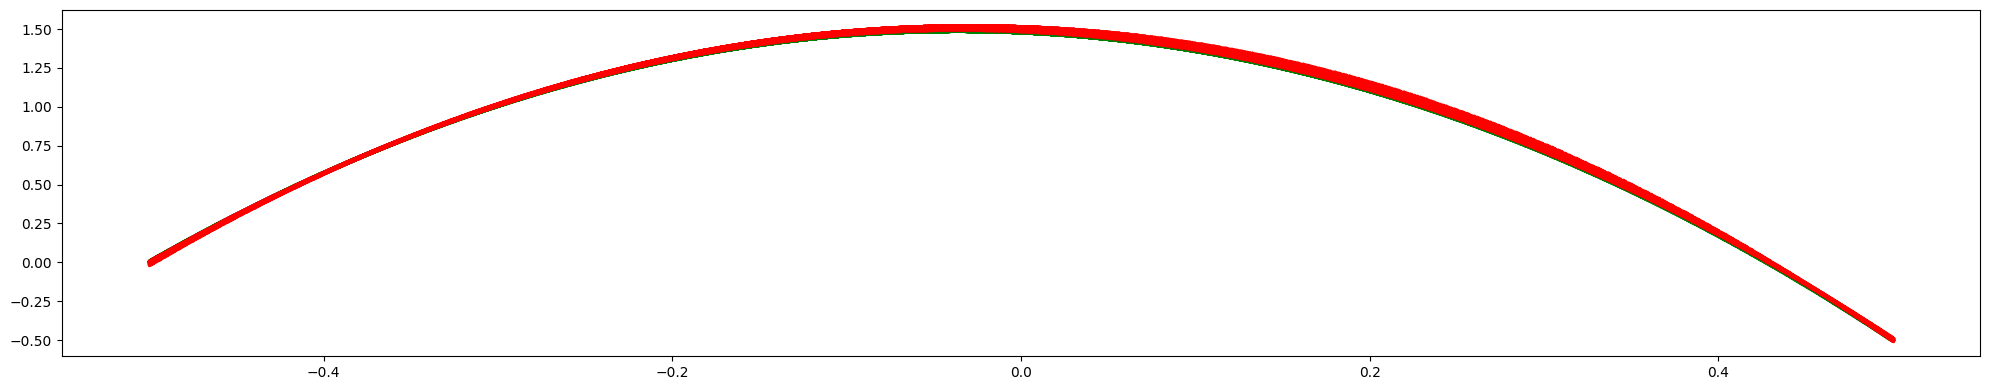

In [ ]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > (D/2 - 0.15)) & (samples[:,0] < (L/2 - 0.15)))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -(D/2 - 0.7)) & (samples[:,0] > -(L/2 - 0.7)))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

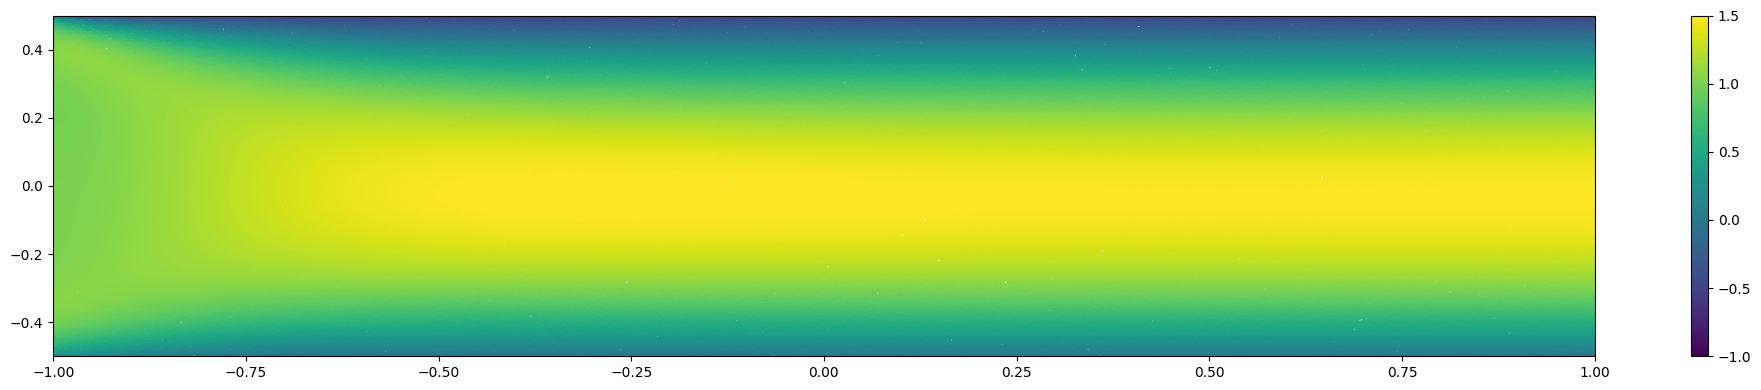

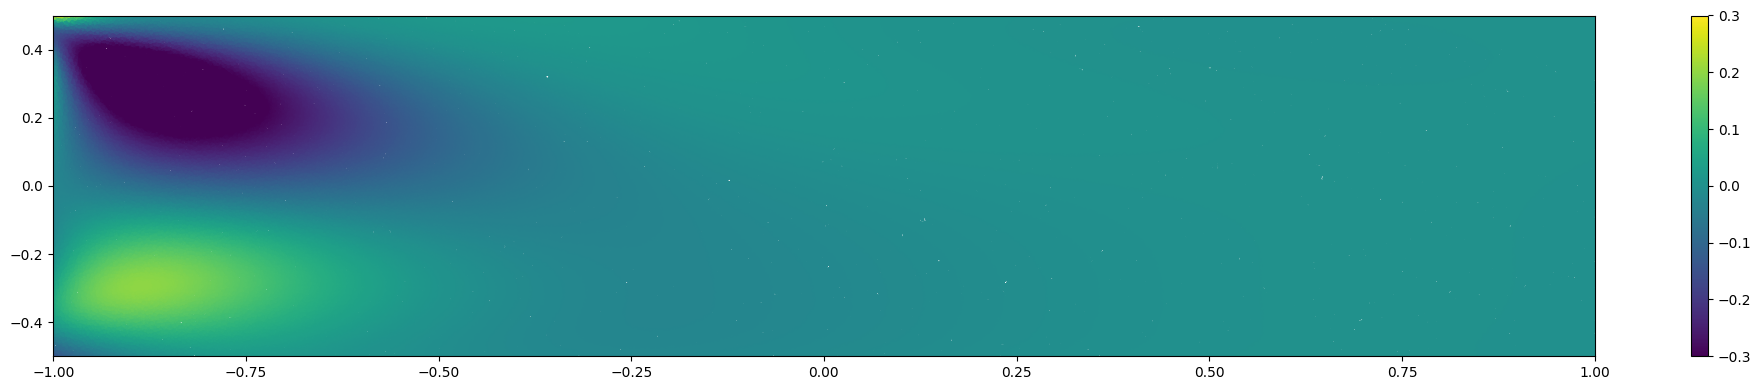

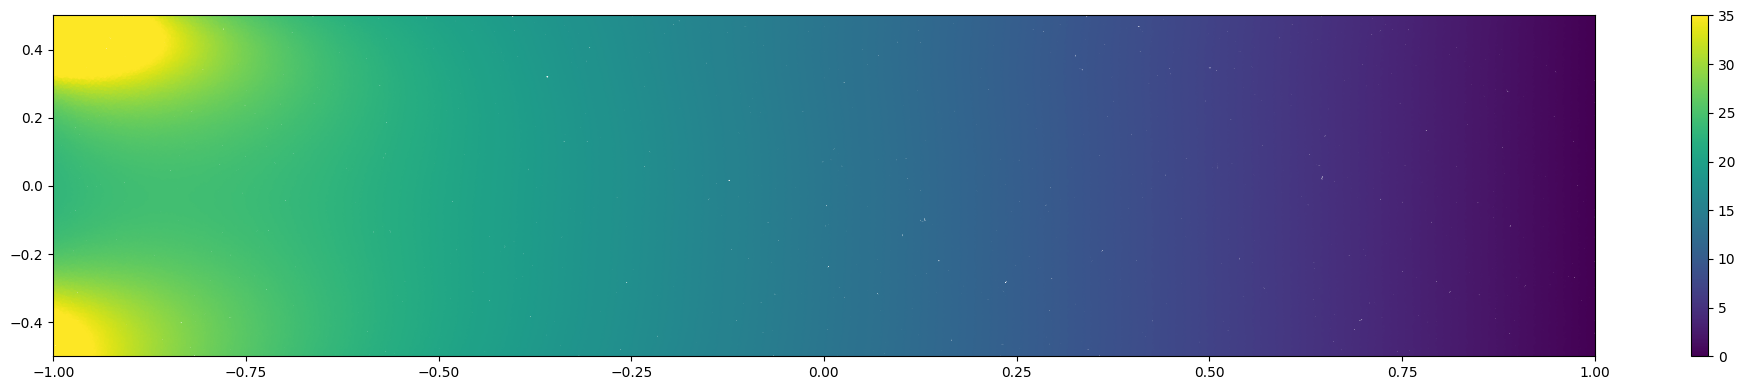

In [ ]:
color_legend = [[-1,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'viridis',
               s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()